# Satellite data 

This notebook loads Copernicus Marine daily L4 SST files (from `....ipynb`) and computes monthly SST anomalies, plus quick maps and a time series (2020-2024). (Might need to edit name opf the Copernicus SSt file)

Here I am looking at what satellite data says, I am considering at investigating SST, 


In [2]:
# 1) Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

# SST
Here I am looking at intraannual SST spatiotemporal variability

In [3]:
ds = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-sst_glo_phy_nrt_l4_P1D-m_2021-2024.nc")
ds

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 1461, latitude: 300, longitude: 500)
Coordinates:
  * latitude      (latitude) float32 1kB 40.05 40.15 40.25 ... 69.75 69.85 69.95
  * longitude     (longitude) float32 2kB -59.95 -59.85 -59.75 ... -10.15 -10.05
  * time          (time) datetime64[ns] 12kB 2021-01-01 ... 2024-12-31
Data variables:
    analysed_sst  (time, latitude, longitude) float64 2GB ...
Attributes:
    history:                   Optimally interpolated SST originally produced...
    Conventions:               CF-1.7, ACDD-1.3, ISO 8601
    source:                    Odyssea L4 processor
    institution:               Institut Francais de Recherche pour l'Exploita...
    title:                     ODYSSEA Global Sea Surface Temperature Gridded...
    references:                Product User Manual for L4 Odyssea Product ove...
    contact:                   emmanuelle.autret@ifremer.fr;jfpiolle@ifremer.fr
    copernicusmarine_version:  2.2.1

In [4]:
sst =ds['analysed_sst']
sst = sst - 273.15  # Convert from Kelvin to Celsius
sst = sst.rename('degC')  # Rename variable for convenience

### Cropping of study location
Not needed as data downloaded to exact location

In [5]:
# Example: same bounds as downloader
lat_name = "lat" if "lat" in sst.dims else "latitude"
lon_name = "lon" if "lon" in sst.dims else "longitude"

# If your longitude is 0..360 and you want negatives, you can convert once:
# if sst[lon_name].max() > 180:
#     sst = sst.assign_coords({lon_name: (((sst[lon_name] + 180) % 360) - 180)}).sortby(lon_name)

sst = sst.sel({lat_name: slice(45, 65), lon_name: slice(-45, -15)})
sst

<xarray.DataArray 'degC' (time: 1461, latitude: 200, longitude: 300)> Size: 701MB
array([[[12.52, 13.  , 13.33, ..., 12.97, 12.92, 12.89],
        [12.28, 12.84, 13.3 , ..., 12.97, 12.92, 12.9 ],
        [11.82, 12.5 , 13.12, ..., 12.94, 12.92, 12.89],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[12.41, 12.87, 13.23, ..., 12.92, 12.86, 12.81],
        [12.17, 12.7 , 13.16, ..., 12.87, 12.81, 12.79],
        [11.75, 12.38, 12.95, ..., 12.81, 12.76, 12.75],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[12.29, 12.76, 13.14, ..., 12.91, 12.84, 12.8 ],
        [12.06, 12.59, 13.03, ..., 12.85, 12.79, 12.75],
        [11.69, 12.27, 12.79, ..., 12.81, 12.73, 12.71],
        ...,
...
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[14.87, 14.71, 14.63, ..., 14.88, 14.84, 14.83],
        [15.  , 14.85, 14.78, ..., 14.96, 14.92, 14.88],
        [15.03, 14.94, 14.89, ..., 15.01, 14.95, 14.92],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[14.57, 14.59, 14.58, ..., 14.8 , 14.78, 14.8 ],
        [14.6 , 14.7 , 14.73, ..., 14.83, 14.81, 14.84],
        [14.64, 14.78, 14.82, ..., 14.86, 14.82, 14.83],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]]],
      shape=(1461, 200, 300))
Coordinates:
  * latitude   (latitude) float32 800B 45.05 45.15 45.25 ... 64.75 64.85 64.95
  * longitude  (longitude) float32 1kB -44.95 -44.85 -44.75 ... -15.15 -15.05
  * time       (time) datetime64[ns] 12kB 2021-01-01 2021-01-02 ... 2024-12-31

### Calculating Monthly mean annomalies

In [6]:
# Monthly means, 12-month climatology, and seasonal anomalies
sst_mon = sst.resample(time='MS').mean()
clim12 = sst_mon.groupby('time.month').mean('time')           # (month, lat, lon)
annual_mean = clim12.mean('month')                             # (lat, lon)
seasonal_anom = clim12 - annual_mean                           # (month, lat, lon)

lon = sst[lon_name].values
lat = sst[lat_name].values

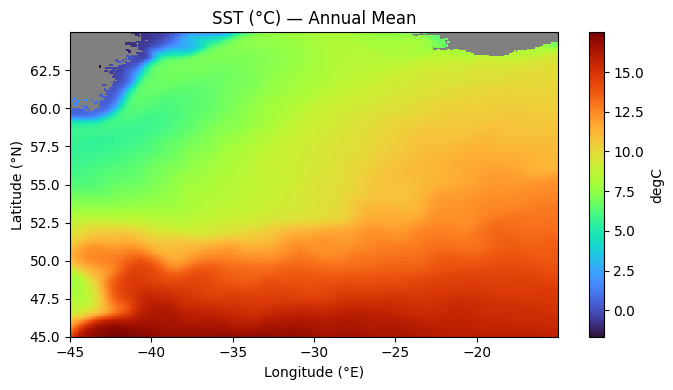

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolor(lon, lat, annual_mean.values, cmap='turbo')  # use cmocean.cm.thermal if available
plt.colorbar(cc, ax=ax, label='degC')
ax.set_title("SST (°C) — Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_27984/756512561.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


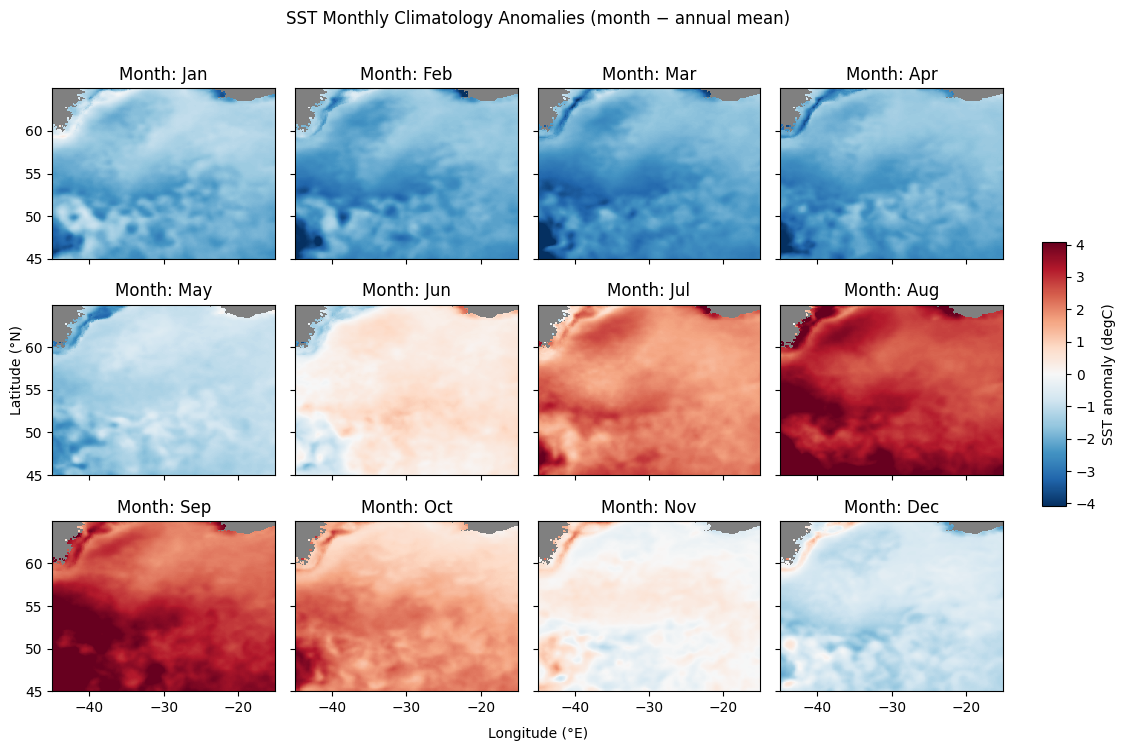

In [8]:
# Symmetric color scale using robust 98th percentile to avoid outliers
vlim = float(np.nanquantile(np.abs(seasonal_anom.values), 0.98))
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = seasonal_anom.isel(month=i).values
    cc_last = ax0.pcolor(lon, lat, da, cmap='RdBu_r', vmin=-vlim, vmax=+vlim)
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right, like the practical
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("SST anomaly (degC)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("SST Monthly Climatology Anomalies (month − annual mean)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()


In [9]:
# Regional SST 

In [10]:
# Sectioning the ocean Basin

# Chlorophyll 
Here a color estimated chlorophyll concentration data was used: https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/download?dataset=cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_202311

In [11]:
dc = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_2021-2024.nc")
dc
CHL = dc['CHL'] # Extracting Back scatter coefficient directly linked with chl concentrations
lat_name = "lat" if "lat" in CHL.dims else "latitude"
lon_name = "lon" if "lon" in CHL.dims else "longitude"

CHL = CHL.sel({lat_name: slice(45, 65), lon_name: slice(-45, -15)})

In [12]:
# Monthly means, 12-month climatology.
CHL_mon = CHL.resample(time='MS').mean()
CHL_clim12 = CHL_mon.groupby('time.month').mean('time')           # (month, lat, lon)
CHL_annual_mean = CHL_clim12.mean('month')                             # (lat, lon)

lon = CHL[lon_name].values
lat = CHL[lat_name].values

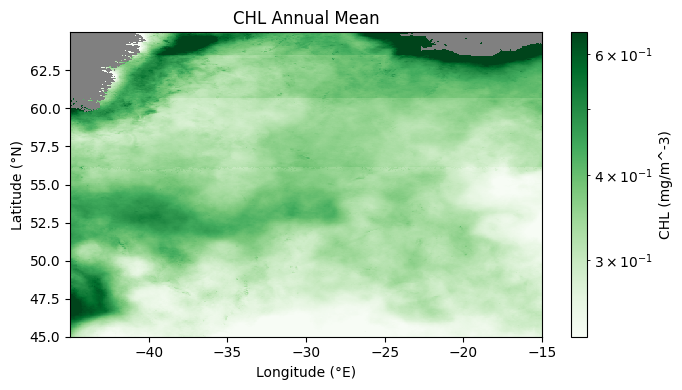

In [13]:
# Robust color scale for positive CHL values (log scale)
_vals = CHL_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL (mg/m^-3)')
ax.set_title("CHL Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_27984/2562950514.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


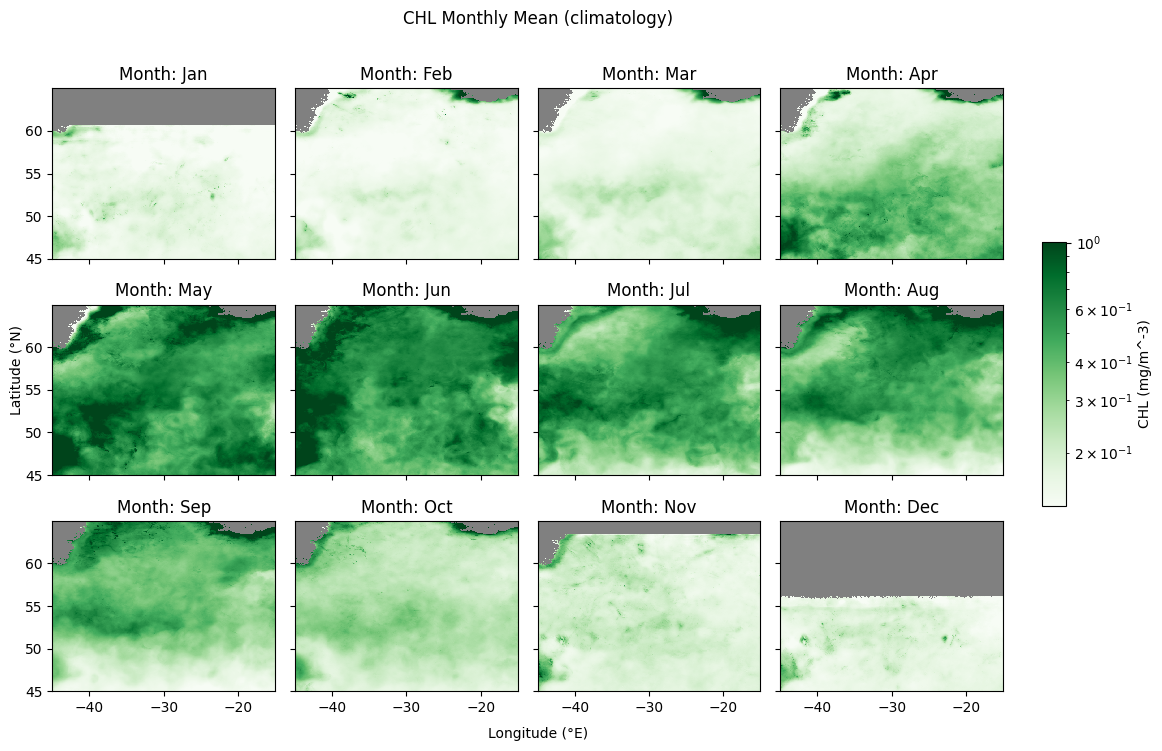

In [14]:
# Robust color scale for positive CHL values across all months (log scale)
_vals = CHL_clim12.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = CHL_clim12.isel(month=i).values
    cc_last = ax0.pcolormesh(
        lon, lat, da, cmap='Greens',
        norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
        shading='auto'
    )
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("CHL (mg/m^-3)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("CHL Monthly Mean (climatology)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()

### Subdividing the region

Futher subdividing the region According to primeraly bathymetry, although I am looking into biogeochemical provences

## BBP 

Here I am using data from Copernicus-GlobColour 1977-ongoing within study range, althougt this back scatter not chlorophyll (https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/description)

In [ ]:
dc = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-oc_glo_bgc-optics_my_l4-multi-4km_P1M_2021-2024.nc")
dc
bbp = dc['BBP'] # Extracting Back scatter coefficient directly linked with chl concentrations
lat_name = "lat" if "lat" in bbp.dims else "latitude"
lon_name = "lon" if "lon" in bbp.dims else "longitude"

bbp = bbp.sel({lat_name: slice(45, 65), lon_name: slice(-45, -15)})

FileNotFoundError: [Errno 2] No such file or directory: '/Users/davidlewis/Desktop/Masters/data/satellite/CMEMS_cmems_obs-oc_glo_bgc-optics_my_l4-multi-4km_P1M_2021-2024.nc'

In [ ]:
# Monthly means, 12-month climatology.
bbp_mon = bbp.resample(time='MS').mean()
bbp_clim12 = bbp_mon.groupby('time.month').mean('time')           # (month, lat, lon)
bbp_annual_mean = bbp_clim12.mean('month')                             # (lat, lon)

lon = bbp[lon_name].values
lat = bbp[lat_name].values

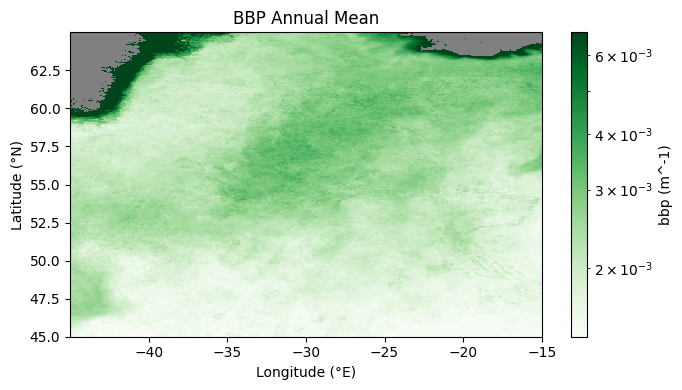

In [ ]:
# Robust color scale for positive bbp values (log scale)
_vals = bbp_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, bbp_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='bbp (m^-1)')
ax.set_title("BBP Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_74293/2047434364.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


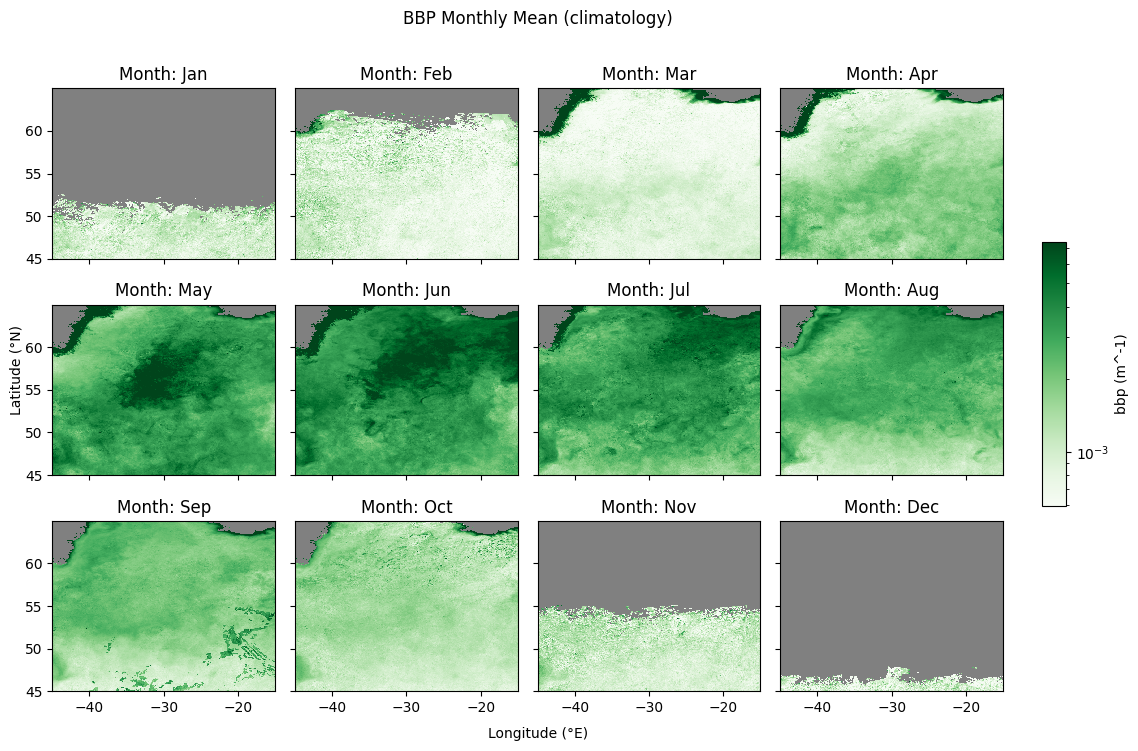

In [ ]:
# Robust color scale for positive bbp values across all months (log scale)
_vals = bbp_clim12.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = bbp_clim12.isel(month=i).values
    cc_last = ax0.pcolormesh(
        lon, lat, da, cmap='Greens',
        norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
        shading='auto'
    )
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("bbp (m^-1)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("BBP Monthly Mean (climatology)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()